In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from dask import bag, diagnostics
from skimage import transform
import cv2

In [56]:
# Chargement des images et redimensionnement des outliers

def load_image(filename: str,  as_gray: bool = False, rescale: float = None) -> np.ndarray:
    '''
    load images from path
    
    Args:
    - filename: str, path
    - as_gray: bool, choose to import as gray
    
    return loaded image as np.array
    '''
    
    if as_gray:
        image = cv2.imread(filename, 0)
        image = cv2.resize(image, (363, 360))
        
    else:
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (363, 360))
        
    if rescale: image = transform.rescale(image, rescale, anti_aliasing=True) # réduction de dimension
    
    return image

In [57]:
# Test chargement d'une image

img = load_image(r"C:\Users\lebre\Documents\Jupyter Notebook\PyBlood\Data\basophil\BA_8742.jpg", as_gray=False)

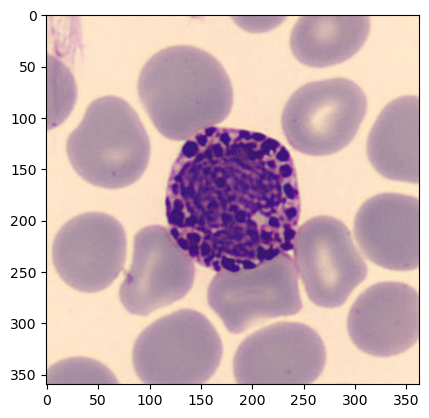

In [58]:
# Affichage de l'image
plt.imshow(img);

In [59]:
# Ajout des colonnes au Dataframe

def add_columns(filename):
    image = cv2.imread(filename)
    temp = pd.DataFrame(index=[0])
    return temp

In [60]:
# Création du Dataframe et récupération des labels

def generate_df_dask(path):
    
    path = Path(path)
    
    df = pd.DataFrame()
    df['img_path'] = [str(image_path) for ext in ['jpg', 'tiff', 'png'] 
                      for image_path in path.glob(f'**/*.{ext}')]
    
    df['classes'] = [image_path.parts[-2] for ext in ['jpg', 'tiff', 'png'] 
                   for image_path in path.glob(f'**/*.{ext}')]

    df['sub_classes'] = [image_path.stem.split('_')[0] 
                     for ext in ['jpg', 'tiff', 'png'] for image_path in path.glob(f'**/*.{ext}')]        
    
    addcol_bag = bag.from_sequence(df.img_path.to_list()).map(add_columns)
    with diagnostics.ProgressBar():
        res = addcol_bag.compute()
        
    res_df = pd.concat(res).reset_index(drop=True)
    df = df.join(res_df)
    return df

In [61]:
df = generate_df_dask(r'C:\Users\lebre\Documents\Jupyter Notebook\PyBlood\Data')

[########################################] | 100% Completed | 57.01 s


In [62]:
df

,img_path,classes,sub_classes
0,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA
1,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA
2,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA
3,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA
4,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,basophil,BA
...,...,...,...
17087,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,platelet,PLATELET
17088,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,platelet,PLATELET
17089,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,platelet,PLATELET
17090,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,platelet,PLATELET


In [63]:
df.describe()

,img_path,classes,sub_classes
count,17092,17092,17092
unique,17092,8,13
top,C:\Users\lebre\Documents\Jupyter Notebook\PyBl...,neutrophil,EO
freq,1,3329,3117


In [64]:
df.classes.value_counts()

neutrophil      3329
eosinophil      3117
ig              2895
platelet        2348
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: classes, dtype: int64

In [65]:
df.sub_classes.value_counts()

EO            3117
PLATELET      2348
SNE           1646
BNE           1633
ERB           1551
MO            1420
BA            1218
LY            1214
MY            1137
MMY           1015
PMY            592
IG             151
NEUTROPHIL      50
Name: sub_classes, dtype: int64

Grâce au value_counts, on remarque que les classes IG et NEUTROPHIL sont sous-représentées.

Parmi la classe des granulocytes immatures (IG), on retrouve les sous-classes suivantes : 
- myélocytes (MY)
- métamyélocytes (MMY)
- promyélocytes (PMY)

De plus, parmi la classe des neutrophiles (NEUTROPHIL), on retrouve les les sous-classes suivantes : 
- neutrophiles segmentés (SNE)
- neutrophiles de bande (BNE)

Par conséquent les classes de cellules IG et NEUTROPHIL dans le label "sub_classes" seront supprimées.

In [43]:
# Suppression des classes IG et NEUTROPHIL
df = df[(df['sub_classes']!='IG') & (df['sub_classes']!='NEUTROPHIL')]

In [44]:
df.to_csv('dataset.csv', index=False)